#Nearest Neighbors for Product Recommendations
In this notebook, we are trying to use nearest neighbors search in embeddings to find similar products. We use two state of the art libraries - FAISS from Facebook and SCANN from Google to do the job! In the process, we learn many many things about them and also how to use them!


## Facebook AI Similarity Search (Faiss)
FAISS was released in 2017 and has become many popular. In this notebook we will compare some of the most important indexes — FlatIP, FlatL2, IVF, LSH, HNSW. We will learn how we decide which to use and the impact of parameters in each index.

## Scalable Nearest Neighbor (ScaNN)
ScaNN was released by Google in 2020. It uses Vector Quantization, Standard vector quantization is not very practical for high dimensional or large scale databases. PQ (product quantization) is a widely used scalable vector quantization method.

PQ divides vectors into multiple subspaces and for each subspace a code book is generated. This approach allows to handle high dimensional vectors and large scale databases.

ScaNN supports several vector search techniques, each with their own tuning parameters. This page explains the basics of the various techniques.

ScaNN performs vector search in three phases. They are described below:

1. Partitioning (optional): ScaNN partitions the dataset during training time, and at query time selects the top partitions to pass onto the scoring stage.
2. Scoring: ScaNN computes the distances from the query to all datapoints in the dataset (if partitioning isn't enabled) or all datapoints in a partition to search (if partitioning is enabled). These distances aren't necessarily exact.
3. Rescoring (optional): ScaNN takes the best k' distances from scoring and re-computes these distances more accurately. From these k' re-computed distances the top k are selected.

***Note-Scoring can either be done with brute-force or asymmetric hashing (AH). The corresponding functions in ScannBuilder are score_brute_force and score_ah. Unless near-perfect accuracy is required, AH gives better speed/accuracy tradeoffs.***


In [ ]:
#importing the libraries

import pandas as pd
import numpy as np
import datetime as dt
import time 

In [ ]:
#loading the data into dataframe
df=pd.read_csv("/content/products.csv")

In [ ]:
%pip install faiss-gpu ##Installing GPU version of faiss

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 9.2 MB/s eta 0:00:00


In [ ]:
%pip install sentence_transformers ## For textual similarity, using pretrained models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 53.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 59.1 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=700fc1a4f7a4c3fad152abd86827262ae6b170b4560ee2aaee1865a046f3a9b7
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence_transformers


In [ ]:
import faiss
from sentence_transformers import SentenceTransformer, util

In [ ]:
# preparing data to feed into the SentenceTransformer model

prod=df.product_name.drop_duplicates()
sentences=prod.tolist()
print("Number of Unique Sentences in Product Name ",len(sentences))

Number of Unique Sentences in Product Name  49688


In [ ]:
# Using pretrained BERT for item embeddings.On GPU Loads the distil roberta model,which was trained on millions of data
model = SentenceTransformer('paraphrase-distilroberta-base-v1') 

In [ ]:
#Generating embeddings for each product

embeddings=model.encode(sentences)

In [ ]:
# saving the embeddings for future purposes
np.save('content\embeddings.npy', embeddings)

In [ ]:
#loading the embeddings
all_embeddings=np.load('embeddings.npy')

In [ ]:
#dim of bert embedding [1, 768]
d = all_embeddings.shape[1]

In [ ]:
faiss.normalize_L2(all_embeddings)

###Performing exhaustive search with Faiss: Flat Index (Inner Product)

In [ ]:
index = faiss.IndexFlatIP(d)
index.is_trained

True

In [ ]:
index.add(all_embeddings)
index.ntotal

49688

In [ ]:
start=time.time()
D_IP, I_IP =index.search(all_embeddings, 15)  # search
end=time.time()
print("Time taken for flat search", (end-start))

Time taken for flat search 70.14369559288025


In [ ]:
#time taken by exhaustive search
IP_time=(end-start)

###Performing exhaustive search with Faiss: Flat Index (Euclidean distance)

In [ ]:
index_L2 = faiss.IndexFlatL2(d)
index_L2.is_trained

True

In [ ]:
index_L2.add(all_embeddings)

In [ ]:
start=time.time()
D_L2, I_L2 =index.search(all_embeddings, 15)  # search
end=time.time()
print("Time taken for flat search", (end-start))

Time taken for flat search 67.2328040599823


In [ ]:
L2_time=(end-start)

###Faiss with Inverted File Index(IVF)

In [ ]:
nlist = 256  # how many cells
quantizer = faiss.IndexFlatL2(d)
index_IVF = faiss.IndexIVFFlat(quantizer, d, nlist)

In [ ]:
#to check if index_IVF is trained. It's False as in case of IVF we have to train the index
index_IVF.is_trained

False

In [ ]:
index_IVF.train(all_embeddings)
index_IVF.is_trained  # check if index is now trained

True

In [ ]:
index_IVF.add(all_embeddings)
index_IVF.ntotal  # number of embeddings indexed

49688

In [ ]:
#searching in 10 more near by cells
index_IVF.nprobe = 10

In [ ]:
#%%time taken by IVF to find top 15 Nearest Neighbors for each unique item in the datset
start=time.time()
D_IVF, I_IVF = index_IVF.search(all_embeddings, 15)  # search
end=time.time()
IVF_time=(end-start)
IVF_time

34.376076459884644

###Faiss Inverted File Index with Product Quantization


In [ ]:
m = 96 # number of centroid IDs in final compressed vectors
bits = 8 # number of bits in each centroid

quantizer = faiss.IndexFlatL2(d)  # we keep the same L2 distance flat index
index_PQ = faiss.IndexIVFPQ(quantizer, d, nlist, m, bits) 

In [ ]:
index_PQ.is_trained

False

In [ ]:
index_PQ.train(all_embeddings)
index_PQ.add(all_embeddings)

In [ ]:
index_PQ.nprobe = 10  # align to previous IndexIVFFlat nprobe value

In [ ]:
#%%time taken by IVF with product quantization to find top 15 Nearest Neighbors for each unique item in the datset
start=time.time()
D_PQ, I_PQ = index_PQ.search(all_embeddings, 15)  # search
end=time.time()
PQ_time=(end-start)
PQ_time

13.74071717262268

In [ ]:
exact_match(I,I_PQ, all_embeddings)

75.79522889497129

###Faiss with Locality Sensitive Hashing(LSH)

In [ ]:
#number of hyperplanes
nbits = 256

# initialize the index using our vectors dimensionality (128) and nbits
index_LSH = faiss.IndexLSH(d, nbits)
# then add the data
index_LSH.train(all_embeddings)
index_LSH.add(all_embeddings)

In [ ]:
#%%time
start=time.time()
D_LSH, I_LSH = index_LSH.search(all_embeddings, k=15)
end=time.time()
LSH_time=(end-start)
LSH_time

5.557265758514404

### Faiss with Hierarchical Navigable Small World Graphs(HNSW)

In [ ]:
# setup our HNSW parameters
M = 50
index_HNSW=faiss.IndexHNSWFlat(d, M)

In [ ]:
#index.hnsw.efConstruction = efConstruction
index_HNSW.add(all_embeddings)  # build the index
#index.hnsw.efSearch = efSearch


In [ ]:
# search time

start=time.time()
D_HNSW, I_HNSW = index_HNSW.search(all_embeddings, k=15)
end=time.time()
HNSW_time=(end-start)
HNSW_time

15.655517578125

In [1]:
%pip install scann

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 19.9 MB/s eta 0:00:00


### Item recommendation with Scalable nearest neighbor (ScaNN)- Scoring with brute-force 

In [ ]:
import scann
k = int(np.sqrt(49688))

In [ ]:
k = int(np.sqrt(49688))
searcher = scann.scann_ops_pybind.builder(all_embeddings, 15, "dot_product").tree(
    num_leaves=500, num_leaves_to_search=int(k/10), training_sample_size=49688).score_brute_force(2).reorder(30).build()

In [ ]:
start = time.time()
neighbors_bf, distances_bf = searcher.search_batched(all_embeddings,final_num_neighbors=15)
end = time.time()

In [ ]:
scnn_bf_time=end-start
scnn_bf_time

8.138118267059326

### Item recommendation with Scalable nearest neighbor (ScaNN)- Scoreing with asymmetric hashing (AH)

In [ ]:
searcher = scann.scann_ops_pybind.builder(all_embeddings, 15, "dot_product").tree(
    num_leaves=500, num_leaves_to_search=int(k/10), training_sample_size=49688).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(30).build()

In [ ]:
start = time.time()
neighbors_aq, distances_aq = searcher.search_batched(all_embeddings,final_num_neighbors=15)
end = time.time()

In [ ]:
ScaNN_AQ_time=end-start
print(end-start)

6.795016765594482


### Comparing performance of Faiss and ScaNN

In [ ]:
y={"Index_IP":IP_time, "Index_Flat":L2_time, "Index_IVF":IVF_time,"Index_IVF_PQ":PQ_time,"Index_LSH":LSH_time,"Index_HNSW":HNSW_time,"ScaNN_brute_force":scnn_bf_time,"ScaNN_asymmetric_hashing":ScaNN_AQ_time}

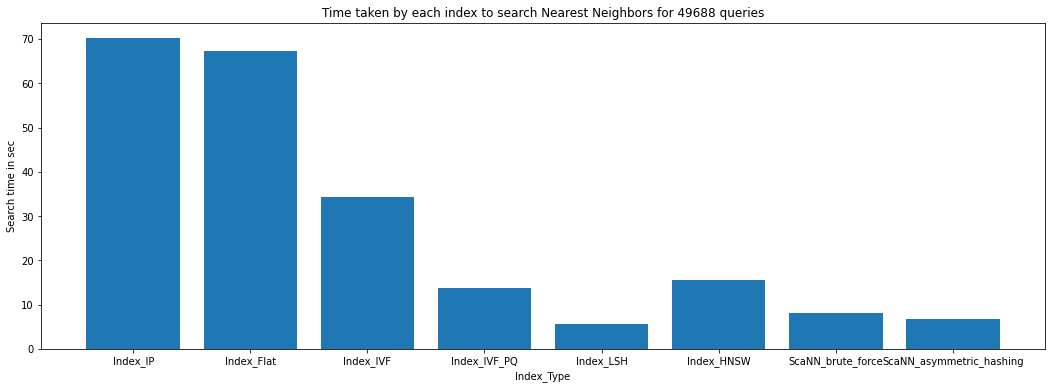

In [ ]:
# Comparing serach time of all the indexes

import matplotlib.pyplot as plt

plt.figure(figsize=(18,6))
plt.bar(*zip(*y.items()))
plt.xlabel("Index_Type")
plt.ylabel("Search time in sec")
plt.title("Time taken by each index to search Nearest Neighbors for 49688 queries")
plt.show()

In [ ]:
# function to return number of common elements in two lists

def intersection(list_a, list_b):
    return len([e for e in list_a if e in list_b ])

In [ ]:
# function to find accuracy 

def exact_match(I,index_comp,all_embeddings):
  len_IVF=0
  k=15
  for i in range(len(all_embeddings)):
    len_IVF+=intersection(I[i],index_comp[i])

  return len_IVF/(k*len(all_embeddings))*100

In [ ]:
a=[]
for i in [I_IP, I_L2,I_IVF,I_PQ,I_LSH,I_HNSW,neighbors_bf, neighbors_aq]:
  a.append(exact_match(I_IP,i,all_embeddings))

In [ ]:
#accuracy of index_HNSW
exact_match(I_IP,I_HNSW,all_embeddings)

97.6043846938228

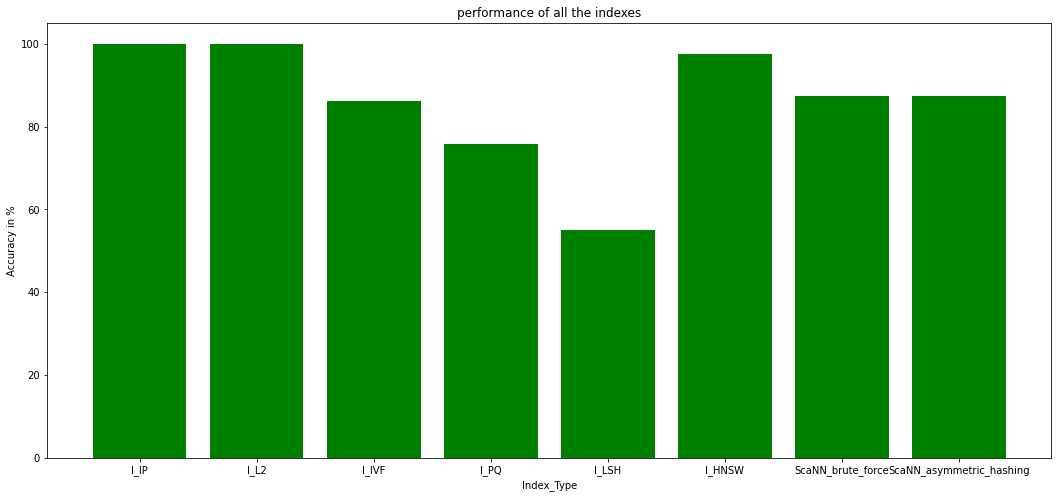

In [ ]:
performance={"I_IP":a[0],"I_L2":a[1],"I_IVF":a[2],"I_PQ":a[3],"I_LSH":a[4],"I_HNSW":a[5],"ScaNN_brute_force":a[6],"ScaNN_asymmetric_hashing":a[7]}
plt.figure(figsize=(18,8))
plt.bar(*zip(*performance.items()),color='green')
plt.xlabel("Index_Type")
plt.ylabel("Accuracy in %")
plt.title("performance of all the indexes")
plt.show()